## Data Cleaning and EDA

Continuing from the previous notebook, we will proceed to perform Data Cleaning and EDA on the data to understand some preliminary trend and process the data in preparation for modeling in the next notebook

### Import the libraries

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import pos_tag

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from datetime import datetime


pd.options.display.max_colwidth = 400

### Import the datasets for both Premier League and Champions League

In [2]:
df_cl = pd.read_csv('../data/cl.csv')
df_epl = pd.read_csv('../data/epl.csv')

In [3]:
df_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 96 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          4299 non-null   int64  
 1   all_awardings                  2800 non-null   object 
 2   allow_live_comments            2624 non-null   object 
 3   author                         4299 non-null   object 
 4   author_flair_css_class         1 non-null      float64
 5   author_flair_richtext          3783 non-null   object 
 6   author_flair_text              72 non-null     object 
 7   author_flair_type              3783 non-null   object 
 8   author_fullname                3798 non-null   object 
 9   author_is_blocked              267 non-null    object 
 10  author_patreon_flair           3205 non-null   object 
 11  author_premium                 2396 non-null   object 
 12  awarders                       2526 non-null   o

In [4]:
df_epl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300 entries, 0 to 2299
Data columns (total 86 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          2300 non-null   int64  
 1   all_awardings                  2300 non-null   object 
 2   allow_live_comments            2300 non-null   bool   
 3   author                         2300 non-null   object 
 4   author_flair_background_color  425 non-null    object 
 5   author_flair_css_class         22 non-null     object 
 6   author_flair_richtext          2285 non-null   object 
 7   author_flair_template_id       447 non-null    object 
 8   author_flair_text              447 non-null    object 
 9   author_flair_text_color        462 non-null    object 
 10  author_flair_type              2285 non-null   object 
 11  author_fullname                2285 non-null   object 
 12  author_is_blocked              2300 non-null   b

In [5]:
#drop the index column on df_cl
df_cl.drop(columns='index', inplace=True)

In [6]:
#drop the index column on df_epl
df_epl.drop(columns='index', inplace=True)

### Clean the data

We are interested in the contents of posts  in each subreddit. This can be found in the `selftext` column.

In [7]:
df_cl['selftext'].unique()

array([nan,
       'In the European Championships, it is difficult to predict, but what are the strongest clubs that have the potential, according to the opinion of 1 Bayern Munich 2 Chelsea 3 man city 4 real Madrid 5 psg 6 man united 7 Liverpool 8 atletico Madrid 9 Barcelona 10 inter Milan 11villarreal 12juventos Write your expectations in the comments, and if there is a club, I did not add it. I am sorry, but we all have different opinions. I hope that you will write the expectations frankly, not because of your love for the club.',
       '# [UEFA Champions League - 2021/2022]\n# Ajax - Besiktas\n\n---\n\n**Match Info**\n\n**Date:** September 28, 2021\n\n**Time:** 16:45 (UTC)\n\n**Venue:** Johan Cruijff Arena\n\n---\n\n**Odds**\n\n| Bookmaker | Home | Draw | Away\n|:-------:|:-----------:|:-----------:|:------:|\nBwin | 1.15 | 8.0 | 17.5 |\nNordicBet | 1.12 | 9.05 | 27.0 |\n10Bet | 1.14 | 9.75 | 18.0 |\nWilliam Hill | 1.14 | 8.0 | 21.0 |\nBet365 | 1.14 | 8.0 | 17.0 |\nMarathonbet | 

In [8]:
df_epl['selftext'].unique()

array(["For me, it's Andy Robertson, dude will fry me with his cold stare.",
       nan,
       'I made chart of the Countries with the most foreign representation in the Premier league for the 2021-2022 season. Minimum 4 players. Any Surprises??',
       'Don´t know which Premier League team to support? \n\nUse this discussion thread to help you choose.',
       '[removed]',
       'Hi,\n\nRight now, Liverpool are doing pretty well. So are ManU. I think man city, though, will win the pl just cuz they have grealish, Kevin, Dias, and a lot of good guys. Chelsea has a chance also, with lukaku and mount and havertz. Either one of these top 4 teams can win. I know the season started kinda recently, but who do you think will take home the trophy?',
       '[removed]\n\n[View Poll](https://www.reddit.com/poll/pwqcir)',
       'Now I already know everyone will beat me up over this, but it’s just a question!! So don’t kill me!!  \n\nWhat if???? Just ask what if??? You can only pass the ball to

A cursory inspection of `selftext` shows the presence of '\[removed\]', '\[deleted\]', null values and empty strings. We will proceed to remove them.

In [9]:
df_cl.drop(index = df_cl[df_cl['selftext']=='[removed]'].index, inplace=True)
df_cl.drop(index = df_cl[df_cl['selftext']=='[deleted]'].index, inplace=True)
df_cl.drop(index = df_cl[df_cl['selftext'].isnull()].index, inplace=True)
df_cl.drop(index = df_cl[df_cl['selftext']==''].index, inplace=True)

In [10]:
df_cl.shape

(960, 95)

In [11]:
df_epl.drop(index = df_epl[df_epl['selftext']=='[removed]'].index, inplace=True)
df_epl.drop(index = df_epl[df_epl['selftext']=='[deleted]'].index, inplace=True)
df_epl.drop(index = df_epl[df_epl['selftext'].isnull()].index, inplace=True)
df_epl.drop(index = df_epl[df_epl['selftext']==''].index, inplace=True)

In [12]:
df_epl.shape

(1013, 85)

We will also proceed to drop duplicated posts in both the `selftext` and `title` columns

In [13]:
df_cl = df_cl.drop_duplicates(subset=['selftext', 'title'])
df_epl = df_epl.drop_duplicates(subset=['selftext', 'title'])

In [14]:
df_cl.shape

(957, 95)

In [15]:
df_epl.shape

(970, 85)

We will now look for duplicated posts within `selftext` and `title` columns individually and replace these duplicated post with empty string accordingly

#### Remove Duplicated Post on `df_cl`

In [16]:
df_cl[['selftext', 'title']][df_cl['title'].duplicated()]

,selftext,title
689,Live streaming Real Madrid vs Chelsea (link in comments),Live streaming Real Madrid vs Chelsea (link in comments)
899,Predictions for Liverpool vs Real Madrid in the champions league\n\n[View Poll](https://www.reddit.com/poll/minsl1),Champions league predictions
900,Predictions for Paris saint germian vs Bayern Munich in the champions league\n\n[View Poll](https://www.reddit.com/poll/minrtb),Champions league predictions
1021,Hello fans! I’m starting a football/soccer site called thefootyreport.com. It’s going to be a website dedicated to editorials and recaps on European ⚽️. We’re looking for writers who may enjoy writing just one article a week for us. I’ll be honest and say that since it’s just starting up there’s no way to make money however there’s a payment plan and the main priority is getting you paid. Fo...,Sports writing opportunity
1076,"\n\nAnyone on Xbox looking to join a full-featured online FIFA career mode?\n\nHey guys, I'm currently a member of an online FIFA career mode -- NAFMO (North American FIFA Manager Online) with just over 20 other members currently through Xbox One, Discord, and Google Sheets. Given the structure that we've refined, it's a full-detailed career mode with transfers, youth academies, cup matches, p...",Looking for FIFA fans interested in joining an online FIFA 21 career mode/league.
1254,[removed]\n\n[View Poll](https://www.reddit.com/poll/kdne0r),Who do you think wins a Ballon dor?
1266,Mon v Manchester City\n\nS.S Lazio v Bayern Munich\n\nAtlético Madrid v Chelsea\n\nRB Leipzig v Liverpool \n\nPorto v Juventus\n\nBarcelona v Paris S G \n\nSevilla v Dortmund\n\nAtalanta v Real Madrid\n\n&amp;#x200B;\n\nThoughts?,Round of 16 draw
1566,[removed]\n\n[View Poll](https://www.reddit.com/poll/j7vqn3),Will Man Utd qualify for the next round?
1568,[removed]\n\n[View Poll](https://www.reddit.com/poll/j7vp3q),Do you think Man Utd will qualify for the next round?
2007,\n\n[View Poll](https://www.reddit.com/poll/i6mrd8),Who will win the match?


In [17]:
title_dup_ind = df_cl[['selftext', 'title']][df_cl['title'].duplicated()].index

title_dup_ind

Int64Index([ 689,  899,  900, 1021, 1076, 1254, 1266, 1566, 1568, 2007, 2078,
            2079, 2085, 2086, 2091, 2092, 2093, 2095, 2209, 2486, 2488, 2910,
            3048, 3861],
           dtype='int64')

In [18]:
for idx in title_dup_ind:
    df_cl.loc[idx,'title']=''

In [19]:
df_cl[['selftext', 'title']][df_cl['selftext'].duplicated()]

,selftext,title
2411,**TODAYS MATCHES STREAMS LINK:** [**CLICK HERE**](https://soccerstream.co/)\n\n**FOR ACESTREAMS CLICK THE FOLLOWING LINK:** [**CLICK HERE**](https://soccerstream.co/)\n\nstreamers please post on the site\n\nfollow us for future matches [click here](https://twitter.com/sportsweed1),Liverpool vs Napoli soccer streams
2423,**TODAYS MATCH STREAMS LINK:** [**CLICK HERE**](https://soccerstream.co/)\n\n**FOR ACESTREAMS CLICK THE FOLLOWING LINK:** [**CLICK HERE**](https://soccerstream.co/)\n\nstreamers please post on the site\n\nfollow us for future matches [click here](https://twitter.com/sportsweed1),Tottenham Hotspur vs Olympiakos Piraeus soccerstreams
2424,**TODAYS MATCH STREAMS LINK:** [**CLICK HERE**](https://soccerstream.co/)\n\n**FOR ACESTREAMS CLICK THE FOLLOWING LINK:** [**CLICK HERE**](https://soccerstream.co/)\n\nstreamers please post on the site\n\nfollow us for future matches [click here](https://twitter.com/sportsweed1),Real Madrid vs PSG soccerstreams
2425,**TODAYS MATCH STREAMS LINK:** [**CLICK HERE**](https://soccerstream.co/)\n\n**FOR ACESTREAMS CLICK THE FOLLOWING LINK:** [**CLICK HERE**](https://soccerstream.co/)\n\nstreamers please post on the site\n\nfollow us for future matches [click here](https://twitter.com/sportsweed1),Manchester City vs Shakhtar Donetsk soccerstreams
2446,**TODAYS MATCH STREAMS LINK:** [**CLICK HERE**](https://twitter.com/sportsweed1)\n\n**FOR ACESTREAMS CLICK THE FOLLOWING LINK:** [**CLICK HERE**](https://twitter.com/sportsweed1)\n\nstreamers please post on the site\n\nfollow us for future matches [click here](https://twitter.com/sportsweed1),[20:00 GMT] PSG vs Club Brugge
2447,**TODAYS MATCH STREAMS LINK:** [**CLICK HERE**](https://twitter.com/sportsweed1)\n\n**FOR ACESTREAMS CLICK THE FOLLOWING LINK:** [**CLICK HERE**](https://twitter.com/sportsweed1)\n\nstreamers please post on the site\n\nfollow us for future matches [click here](https://twitter.com/sportsweed1),Real Madrid vs Galatasaray soccer streams
2448,**TODAYS MATCH STREAMS LINK:** [**CLICK HERE**](https://twitter.com/sportsweed1)\n\n**FOR ACESTREAMS CLICK THE FOLLOWING LINK:** [**CLICK HERE**](https://twitter.com/sportsweed1)\n\nstreamers please post on the site\n\nfollow us for future matches [click here](https://twitter.com/sportsweed1),[20:00 GMT] Atalanta vs Manchester City
2450,**TODAYS MATCH STREAMS LINK:** [**CLICK HERE**](https://twitter.com/sportsweed1)\n\n**FOR ACESTREAMS CLICK THE FOLLOWING LINK:** [**CLICK HERE**](https://twitter.com/sportsweed1)\n\nstreamers please post on the site\n\nfollow us for future matches [click here](https://twitter.com/sportsweed1),Lokomotiv Moskva vs Juventus Reddit Soccer streams
2457,**TODAYS MATCH STREAMS LINK:** [**CLICK HERE**](https://twitter.com/sportsweed1)\n\n**FOR ACESTREAMS CLICK THE FOLLOWING LINK:** [**CLICK HERE**](https://twitter.com/sportsweed1)\n\nstreamers please post on the site\n\nfollow us for future matches [click here](https://twitter.com/sportsweed1),Olympique Lyonnais vs Benfica soccer reddit soccer streams
2458,**TODAYS MATCH STREAMS LINK:** [**CLICK HERE**](https://twitter.com/sportsweed1)\n\n**FOR ACESTREAMS CLICK THE FOLLOWING LINK:** [**CLICK HERE**](https://twitter.com/sportsweed1)\n\nstreamers please post on the site\n\nfollow us for future matches [click here](https://twitter.com/sportsweed1),Chelsea vs Ajax soccer reddit soccer streams


In [20]:
selftext_dup_ind = df_cl[['selftext', 'title']][df_cl['selftext'].duplicated()].index

selftext_dup_ind

Int64Index([2411, 2423, 2424, 2425, 2446, 2447, 2448, 2450, 2457, 2458, 2459,
            2461, 2462, 2476, 2485, 2487, 2488, 2490, 2500, 2501, 2537, 2553,
            2840, 2882, 2897, 2960, 2979, 3000, 3002, 3042],
           dtype='int64')

In [21]:
for idx in selftext_dup_ind:
    df_cl.loc[idx,'selftext']=''

#### Remove Duplicated Post on `df_epl`

In [22]:
df_epl[['selftext', 'title']][df_epl['title'].duplicated()]

,selftext,title
1664,[removed]\n\n[View Poll](https://www.reddit.com/poll/pa8ey4),Where does Jorginho place in the Ballon D’Or?


In [23]:
title_dup_ind = df_epl[['selftext', 'title']][df_epl['title'].duplicated()].index

title_dup_ind

Int64Index([1664], dtype='int64')

In [24]:
for idx in title_dup_ind:
    df_epl.loc[idx,'title']=''

In [25]:
df_epl[['selftext', 'title']][df_epl['selftext'].duplicated()]

,selftext,title


####  Combine `selftext` and `title`

We will now combine `selftext` and `title` on both `df_cl` and `df_epl`

In [26]:
df_cl['selftext'] = df_cl['selftext'] + df_cl['title']

In [27]:
df_cl[['selftext']]

,selftext
2,"In the European Championships, it is difficult to predict, but what are the strongest clubs that have the potential, according to the opinion of 1 Bayern Munich 2 Chelsea 3 man city 4 real Madrid 5 psg 6 man united 7 Liverpool 8 atletico Madrid 9 Barcelona 10 inter Milan 11villarreal 12juventos Write your expectations in the comments, and if there is a club, I did not add it. I am sorry, but w..."
4,"# [UEFA Champions League - 2021/2022]\n# Ajax - Besiktas\n\n---\n\n**Match Info**\n\n**Date:** September 28, 2021\n\n**Time:** 16:45 (UTC)\n\n**Venue:** Johan Cruijff Arena\n\n---\n\n**Odds**\n\n| Bookmaker | Home | Draw | Away\n|:-------:|:-----------:|:-----------:|:------:|\nBwin | 1.15 | 8.0 | 17.5 |\nNordicBet | 1.12 | 9.05 | 27.0 |\n10Bet | 1.14 | 9.75 | 18.0 |\nWilliam Hill | 1.14 | 8.0..."
9,"If Pep Guardiola’s Barcelona from 2008-2012 faced Hansi Flick’s Bayern Munich from 2019-2021, who would win? Would the Germans do another 8:2 or will the Spanish get the best of the Germans.\n\n[View Poll](https://www.reddit.com/poll/pvffu7)Pep Guardiola’s Barcelona VS Hansi Flick’s Bayern Munich? Who would win?"
16,"Hi,\n\nI'm aware that PSG and Bayern are *both* favorites to win the CL 2022, along with Man City. But I just have this feeling that PSG may or may not win it. They have Messi, Mbappe, and Ramos, to name a few...a formidable squad. Bayern, though, has Lewandowski Muller, and Kimmich, who are basically the top players in the world for their respective positions. Plus, come to look at Bundesliga..."
21,Manchester United faced off against Young Boys in the first game of the champions league on Tuesday and were the first team to lose in the competition this season. A brutal loss in a game that they deserved to go home with atleast a point. However a costly error in the dying seconds of the game was all that those young boys needed to secure the first win of the competition.\n\nCasting our mind...
...,...
4269,What do you guys think are the highlights of this season's champions league as of now? Highlights of this season's UCL till now?
4290,"I'm not an english native speaker so I didn't get the news from a link i can post here to show you all. But i'm sure it won't be hard to find one.\n\nShortly saying, they want to change it so traditional clubs won't stay out. This season, BVB Dortmund, Liverpool, Ajax, Milan and Inter are out (These have 20 trophies altogether). Next one, Man U, Liverpool, Chelsea and both from Milan are in se..."
4291,"The round of 16 of the Champions League kicks-off on the 17th of February and today we discuss one of the most exciting fixtures, Arsenal v Barcelona. Arsenal FC host the current champions FC Barcelona on 24th February 2016, a fixture that is guaranteed to produce goals and excitement. Barcelona last played Arsenal in 2011 when they won 4-3 on aggregate. Both teams have changed a lot since tha..."
4292,Hear me out. I'm sure the rules have changed with what happens now.\n\nSo let's assume the top 4 stays as it is. \n\nChelsea wins the CL\n\nUnited wins Europa. \n\nWould that mean all 6 teams go in or does one or more teams lose out? \n\nI know it's unlikely. But would be wonderful to see.Could there be 6 English Teams in the Champions league next season?


In [28]:
df_epl['selftext'] = df_epl['selftext'] + df_epl['title']

In [29]:
df_epl[['selftext']]

,selftext
0,"For me, it's Andy Robertson, dude will fry me with his cold stare.Which Premier League player would you never mess with?"
2,I made chart of the Countries with the most foreign representation in the Premier league for the 2021-2022 season. Minimum 4 players. Any Surprises??Countries with the Most Players in the Prem(Foreign)
3,"Don´t know which Premier League team to support? \n\nUse this discussion thread to help you choose.Weekly ""Who should I root for"" discussion thread"
12,"Hi,\n\nRight now, Liverpool are doing pretty well. So are ManU. I think man city, though, will win the pl just cuz they have grealish, Kevin, Dias, and a lot of good guys. Chelsea has a chance also, with lukaku and mount and havertz. Either one of these top 4 teams can win. I know the season started kinda recently, but who do you think will take home the trophy?Who do you think will win?"
13,[removed]\n\n[View Poll](https://www.reddit.com/poll/pwqcir)💪‍Thomas Partey Vs Tottenham
...,...
2282,[removed]\n\n[View Poll](https://www.reddit.com/poll/p3ujga)Rank these teams
2285,What’s the name of that song that brentford fans were chanting after the win?Brentford song chant name?
2286,What is the best team in the premier League eraBest team in the premier League era
2291,"Will be nice to see the boys stand in solidarity against the 65k migrant workers who died building the stadiumsSince the England national team stands against oppression and inequity, when do you think they will announcing pulling out of Qatar 2020?"


#### Remove url from `selftext`

We will define a function to replace all urls in `selftext` with empty string

In [30]:
def remove_url(string):
    return re.sub(r'\[http.+\]|\(http.+\)|http\S+', '', string)

We will now remove url from `selftext` in `df_epl` and `df_cl`

In [31]:
df_cl['selftext'] = df_cl['selftext'].map(remove_url)
df_epl['selftext'] = df_epl['selftext'].map(remove_url)

Checking for any remaining url in the `df_cl` and `df_epl` `selftext`

In [32]:
df_cl['http'] = df_cl['selftext'].map(lambda x: 1 if len(re.findall('http', x))>0 else 0)
df_cl[df_cl['http']==1]

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,...,gilded,rte_mode,author_id,brand_safe,suggested_sort,approved_at_utc,banned_at_utc,view_count,author_created_utc,http


In [33]:
df_epl['http'] = df_epl['selftext'].map(lambda x: 1 if len(re.findall('http', x))>0 else 0)
df_epl[df_epl['http']==1]

,all_awardings,allow_live_comments,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,author_flair_type,...,crosspost_parent_list,gallery_data,is_gallery,media_metadata,discussion_type,distinguished,author_cakeday,poll_data,edited,http


#### Drop rows with `selftext` containing empty strings

In [34]:
df_cl.shape

(957, 96)

In [35]:
df_cl.drop(df_cl[df_cl['selftext']==''].index, inplace=True)

In [36]:
df_cl.shape

(956, 96)

In [37]:
df_epl.shape

(970, 86)

In [38]:
df_epl.drop(df_epl[df_epl['selftext']==''].index, inplace=True)

In [39]:
df_epl.shape

(969, 86)

#### Convert `created_utc` to date format

In [40]:
df_cl['created_utc'] = df_cl['created_utc'].map(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d'))

In [41]:
df_cl['created_utc']

2       2021-09-27
4       2021-09-27
9       2021-09-25
16      2021-09-23
21      2021-09-19
           ...    
4269    2016-02-25
4290    2016-02-10
4291    2016-02-04
4292    2016-01-16
4294    2015-12-23
Name: created_utc, Length: 956, dtype: object

In [42]:
df_epl['created_utc'] = df_epl['created_utc'].map(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d'))

In [43]:
df_epl['created_utc']

0       2021-09-28
2       2021-09-28
3       2021-09-28
12      2021-09-27
13      2021-09-27
           ...    
2282    2021-08-13
2285    2021-08-13
2286    2021-08-13
2291    2021-08-13
2294    2021-08-13
Name: created_utc, Length: 969, dtype: object

#### Keep only `selftext`, `created_utc` and `post_hint` from `df_cl` and `df_epl`

In [44]:
df_cl = df_cl[['created_utc', 'selftext', 'post_hint']].reset_index(drop=True)
df_epl = df_epl[['created_utc', 'selftext', 'post_hint']].reset_index(drop=True)

In [45]:
df_cl.head()

,created_utc,selftext,post_hint
0,2021-09-27,"In the European Championships, it is difficult to predict, but what are the strongest clubs that have the potential, according to the opinion of 1 Bayern Munich 2 Chelsea 3 man city 4 real Madrid 5 psg 6 man united 7 Liverpool 8 atletico Madrid 9 Barcelona 10 inter Milan 11villarreal 12juventos Write your expectations in the comments, and if there is a club, I did not add it. I am sorry, but w...",NaN
1,2021-09-27,"# [UEFA Champions League - 2021/2022]\n# Ajax - Besiktas\n\n---\n\n**Match Info**\n\n**Date:** September 28, 2021\n\n**Time:** 16:45 (UTC)\n\n**Venue:** Johan Cruijff Arena\n\n---\n\n**Odds**\n\n| Bookmaker | Home | Draw | Away\n|:-------:|:-----------:|:-----------:|:------:|\nBwin | 1.15 | 8.0 | 17.5 |\nNordicBet | 1.12 | 9.05 | 27.0 |\n10Bet | 1.14 | 9.75 | 18.0 |\nWilliam Hill | 1.14 | 8.0...",NaN
2,2021-09-25,"If Pep Guardiola’s Barcelona from 2008-2012 faced Hansi Flick’s Bayern Munich from 2019-2021, who would win? Would the Germans do another 8:2 or will the Spanish get the best of the Germans.\n\n[View Poll]Pep Guardiola’s Barcelona VS Hansi Flick’s Bayern Munich? Who would win?",NaN
3,2021-09-23,"Hi,\n\nI'm aware that PSG and Bayern are *both* favorites to win the CL 2022, along with Man City. But I just have this feeling that PSG may or may not win it. They have Messi, Mbappe, and Ramos, to name a few...a formidable squad. Bayern, though, has Lewandowski Muller, and Kimmich, who are basically the top players in the world for their respective positions. Plus, come to look at Bundesliga...",NaN
4,2021-09-19,Manchester United faced off against Young Boys in the first game of the champions league on Tuesday and were the first team to lose in the competition this season. A brutal loss in a game that they deserved to go home with atleast a point. However a costly error in the dying seconds of the game was all that those young boys needed to secure the first win of the competition.\n\nCasting our mind...,NaN


In [46]:
df_epl.head()

,created_utc,selftext,post_hint
0,2021-09-28,"For me, it's Andy Robertson, dude will fry me with his cold stare.Which Premier League player would you never mess with?",NaN
1,2021-09-28,I made chart of the Countries with the most foreign representation in the Premier league for the 2021-2022 season. Minimum 4 players. Any Surprises??Countries with the Most Players in the Prem(Foreign),NaN
2,2021-09-28,"Don´t know which Premier League team to support? \n\nUse this discussion thread to help you choose.Weekly ""Who should I root for"" discussion thread",NaN
3,2021-09-27,"Hi,\n\nRight now, Liverpool are doing pretty well. So are ManU. I think man city, though, will win the pl just cuz they have grealish, Kevin, Dias, and a lot of good guys. Chelsea has a chance also, with lukaku and mount and havertz. Either one of these top 4 teams can win. I know the season started kinda recently, but who do you think will take home the trophy?Who do you think will win?",NaN
4,2021-09-27,[removed]\n\n[View Poll]💪‍Thomas Partey Vs Tottenham,NaN


#### Create a column `championsleague` as label for whether the post came from r/championsleague or r/PremierLeague

In [47]:
df_cl['championsleague']=1
df_epl['championsleague']=0

In [48]:
df_cl.head()

,created_utc,selftext,post_hint,championsleague
0,2021-09-27,"In the European Championships, it is difficult to predict, but what are the strongest clubs that have the potential, according to the opinion of 1 Bayern Munich 2 Chelsea 3 man city 4 real Madrid 5 psg 6 man united 7 Liverpool 8 atletico Madrid 9 Barcelona 10 inter Milan 11villarreal 12juventos Write your expectations in the comments, and if there is a club, I did not add it. I am sorry, but w...",NaN,1
1,2021-09-27,"# [UEFA Champions League - 2021/2022]\n# Ajax - Besiktas\n\n---\n\n**Match Info**\n\n**Date:** September 28, 2021\n\n**Time:** 16:45 (UTC)\n\n**Venue:** Johan Cruijff Arena\n\n---\n\n**Odds**\n\n| Bookmaker | Home | Draw | Away\n|:-------:|:-----------:|:-----------:|:------:|\nBwin | 1.15 | 8.0 | 17.5 |\nNordicBet | 1.12 | 9.05 | 27.0 |\n10Bet | 1.14 | 9.75 | 18.0 |\nWilliam Hill | 1.14 | 8.0...",NaN,1
2,2021-09-25,"If Pep Guardiola’s Barcelona from 2008-2012 faced Hansi Flick’s Bayern Munich from 2019-2021, who would win? Would the Germans do another 8:2 or will the Spanish get the best of the Germans.\n\n[View Poll]Pep Guardiola’s Barcelona VS Hansi Flick’s Bayern Munich? Who would win?",NaN,1
3,2021-09-23,"Hi,\n\nI'm aware that PSG and Bayern are *both* favorites to win the CL 2022, along with Man City. But I just have this feeling that PSG may or may not win it. They have Messi, Mbappe, and Ramos, to name a few...a formidable squad. Bayern, though, has Lewandowski Muller, and Kimmich, who are basically the top players in the world for their respective positions. Plus, come to look at Bundesliga...",NaN,1
4,2021-09-19,Manchester United faced off against Young Boys in the first game of the champions league on Tuesday and were the first team to lose in the competition this season. A brutal loss in a game that they deserved to go home with atleast a point. However a costly error in the dying seconds of the game was all that those young boys needed to secure the first win of the competition.\n\nCasting our mind...,NaN,1


In [49]:
df_epl.head()

,created_utc,selftext,post_hint,championsleague
0,2021-09-28,"For me, it's Andy Robertson, dude will fry me with his cold stare.Which Premier League player would you never mess with?",NaN,0
1,2021-09-28,I made chart of the Countries with the most foreign representation in the Premier league for the 2021-2022 season. Minimum 4 players. Any Surprises??Countries with the Most Players in the Prem(Foreign),NaN,0
2,2021-09-28,"Don´t know which Premier League team to support? \n\nUse this discussion thread to help you choose.Weekly ""Who should I root for"" discussion thread",NaN,0
3,2021-09-27,"Hi,\n\nRight now, Liverpool are doing pretty well. So are ManU. I think man city, though, will win the pl just cuz they have grealish, Kevin, Dias, and a lot of good guys. Chelsea has a chance also, with lukaku and mount and havertz. Either one of these top 4 teams can win. I know the season started kinda recently, but who do you think will take home the trophy?Who do you think will win?",NaN,0
4,2021-09-27,[removed]\n\n[View Poll]💪‍Thomas Partey Vs Tottenham,NaN,0


#### Combine `df_cl` and `df_epl` into one DataFrame `df_sub`

In [50]:
df_sub = pd.concat([df_cl, df_epl]).reset_index(drop=True)

In [51]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   created_utc      1925 non-null   object
 1   selftext         1925 non-null   object
 2   post_hint        235 non-null    object
 3   championsleague  1925 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 60.3+ KB


### Exploratory Data Analysis

We wish to see on which day of the week are there more posts between r/championsleague and r/PremierLeague

In [52]:
df_cl['post_weekday'] = pd.to_datetime(df_cl['created_utc']).dt.weekday

In [53]:
df_epl['post_weekday'] = pd.to_datetime(df_epl['created_utc']).dt.weekday

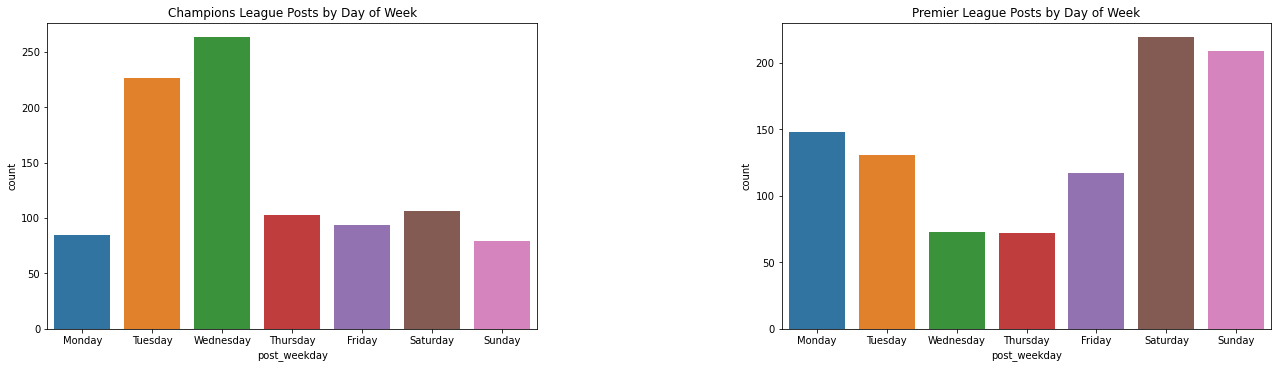

In [79]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 5)
plt.subplots_adjust(left=0.1,
                bottom=0.1,
                right=0.95,
                top=0.95,
                wspace=0.5,
                hspace=0.5)

df = [df_cl, df_epl]
reddit = ['Champions League Posts by Day of Week', 'Premier League Posts by Day of Week']

for dataf, subplot, sub in zip(df, ax.flatten(), reddit):
    sns.countplot(x='post_weekday',
                  data=dataf,
                  ax=subplot,
                  )
    subplot.title.set_text(sub)
    subplot.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);


**Key Observation:**

The bar chart confirms what avid football fan already know:

1. The post counts are higher on Tuesdays and Wednesday for UEFA Champions League, as most matches are played on Tuesday and Wednesday evening

2. The post counts are higher on Saturdays and Sundays for English Premier League as they are typically played on Saturday and Sunday afternoons.


**Types of Posts**

Not all posts in reddit are text posts. In football related subreddits, posts tend to be images or video clips of match highlights. We will now look at the distribution of post type using `post_hint` for both r/championsleague and r/PremierLeague on the raw scrapes.

In [55]:
#import the raw scrapes
df_cl_raw = pd.read_csv('../data/cl.csv')
df_epl_raw = pd.read_csv('../data/epl.csv')

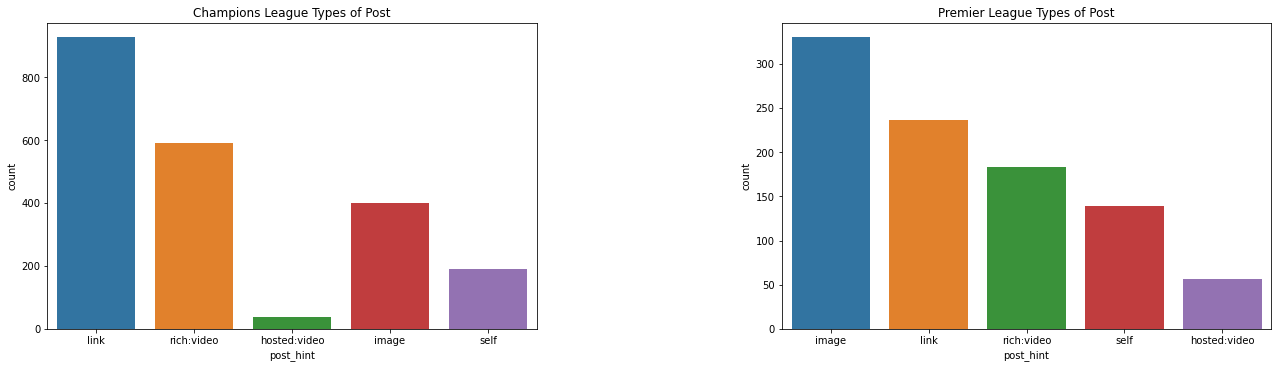

In [56]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 5)
plt.subplots_adjust(left=0.1,
                bottom=0.1,
                right=0.95,
                top=0.95,
                wspace=0.5,
                hspace=0.5)

df = [df_cl_raw, df_epl_raw]
reddit = ['Champions League Types of Post', 'Premier League Types of Post']

for dataf, subplot, sub in zip(df, ax.flatten(), reddit):
    sns.countplot(x='post_hint',
                  data=dataf,
                  ax=subplot,
                  )
    subplot.title.set_text(sub);


**Key Observation:**

1. There are a lot of posts which are links, videos and images than self(which is text) on both r/championsleague and r/PremierLeague. This is to be expected given that users tend to share video clips (or links of the clips) of match highlights of the previous day.

**Most Frequent Words**

We will now see what are the common words on both r/PremierLeague and r/championsleague

In [57]:
X_cl = df_cl['selftext']
X_epl = df_epl['selftext']

In [58]:
cvec_cl = CountVectorizer(stop_words=['to', 'you', 'the', 'and', 'in', 'is', 'my', 'me', 'it', 'for', 'your',
                       'of', 'that', 'have', 'on', 'now', 'are', 'so', 'can','this', 'be', 'they', 'but', 'will',
                       'all', 'if', 'who', 'or', 'by', 'he', 'not', 'what', 'from', 'would', 'like',
                       'with', 'at', 'wa','do', 'their', 'get', 'ha', 'just', 'one', 'no', 'we', 'off',
                       'there', 'know', 'how', 'about', 'up', 'against', 'been', 'an', 'his', 'more',
                       'which', 'most', 'them', 'any', 'last', 'why', 'some', 'could', 'only', 'should',
                       'don', 'had', 'after', 'when', 'where', 'back', 'make', 've', 'also', 'other', 
                       'very', 'really', 'here', 'even', 'am', 'were', 'into', 'being', 'because', 'than',
                       'yet', 'anyone', 'go'])

X_cl = cvec_cl.fit_transform(X_cl)

In [59]:
cl_vec = pd.DataFrame(X_cl.todense(),
                         columns=cvec_cl.get_feature_names())

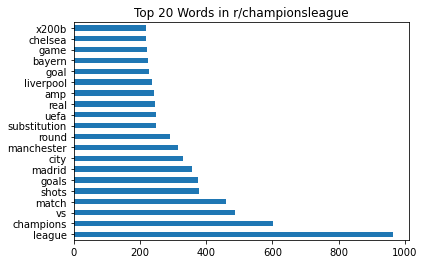

In [60]:
cl_vec.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Top 20 Words in r/championsleague");

In [61]:
cvec_epl = CountVectorizer(stop_words=['to', 'you', 'the', 'and', 'in', 'is', 'my', 'me', 'it', 'for', 'your',
                       'of', 'that', 'have', 'on', 'now', 'are', 'so', 'can','this', 'be', 'they', 'but', 'will',
                       'all', 'if', 'who', 'or', 'by', 'he', 'not', 'what', 'from', 'would', 'like',
                       'with', 'at', 'wa','do', 'their', 'get', 'ha', 'just', 'one', 'no', 'we', 'off',
                       'there', 'know', 'how', 'about', 'up', 'against', 'been', 'an', 'his', 'more',
                       'which', 'most', 'them', 'any', 'last', 'why', 'some', 'could', 'only', 'should',
                       'don', 'had', 'after', 'when', 'where', 'back', 'make', 've', 'also', 'other', 
                       'very', 'really', 'here', 'even', 'am', 'were', 'into', 'being', 'because', 'than',
                       'yet', 'anyone', 'go'])

X_epl = cvec_epl.fit_transform(X_epl)

In [62]:
epl_vec = pd.DataFrame(X_epl.todense(),
                         columns=cvec_epl.get_feature_names())

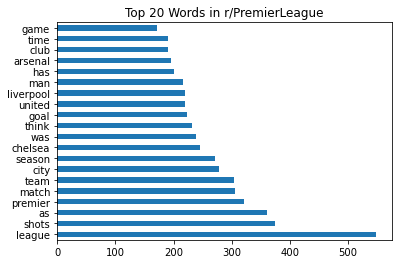

In [63]:
epl_vec.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Top 20 Words in r/PremierLeague");

**Most Frequent Bigrams**

We will now see what are the common bigrams on both r/PremierLeague and r/championsleague

In [64]:
X_cl = df_cl['selftext']
X_epl = df_epl['selftext']

In [65]:
cvec_bi_cl = CountVectorizer(ngram_range = (2,2))

X_cl = cvec_bi_cl.fit_transform(X_cl)

In [66]:
cl_vec_bi = pd.DataFrame(X_cl.todense(),
                         columns=cvec_bi_cl.get_feature_names())

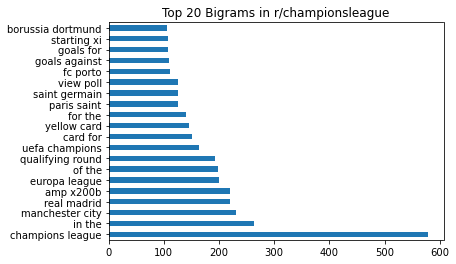

In [67]:
cl_vec_bi.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Top 20 Bigrams in r/championsleague");

In [68]:
cvec_bi_epl = CountVectorizer(ngram_range = (2,2))

X_epl = cvec_bi_epl.fit_transform(X_epl)

In [69]:
epl_vec_bi = pd.DataFrame(X_epl.todense(),
                         columns=cvec_bi_epl.get_feature_names())

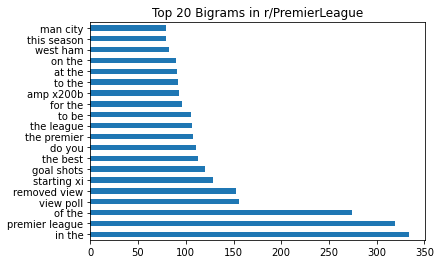

In [70]:
epl_vec_bi.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Top 20 Bigrams in r/PremierLeague");

**Most Frequent Trigrams**

Lastly, we will now look at what are the common trigrams on both r/PremierLeague and r/championsleague

In [71]:
X_cl = df_cl['selftext']
X_epl = df_epl['selftext']

In [72]:
cvec_tri_cl = CountVectorizer(ngram_range = (3,3))

X_cl = cvec_tri_cl.fit_transform(X_cl)

In [73]:
cl_vec_tri = pd.DataFrame(X_cl.todense(),
                          columns=cvec_tri_cl.get_feature_names())

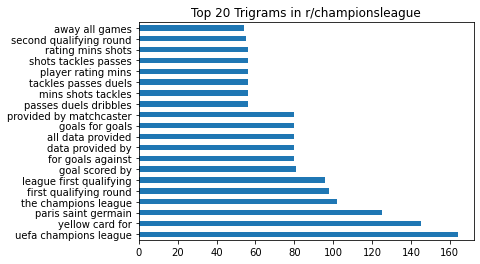

In [74]:
cl_vec_tri.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Top 20 Trigrams in r/championsleague");

In [75]:
cvec_tri_epl = CountVectorizer(ngram_range = (3,3))

X_epl = cvec_tri_epl.fit_transform(X_epl)

In [76]:
epl_vec_tri = pd.DataFrame(X_epl.todense(),
                           columns=cvec_tri_epl.get_feature_names())

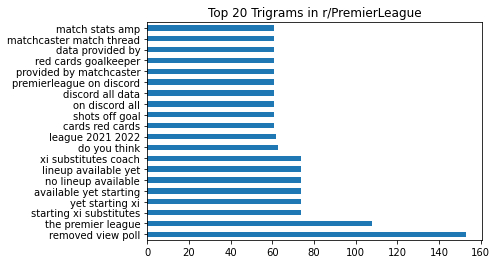

In [77]:
epl_vec_tri.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Top 20 Trigrams in r/PremierLeague");

**Key Observation:**

1. The most common unigrams, bigrams and trigrams in both r/championsleague and r/PremierLeague provides very useful data on what stop words to include later when we tokenize the combined dataset `df_sub` for modeling in the next notebook.

2. The unigrams and bigrams reveal common words in football such as 'goal', 'game', 'yellow card' regardless of the competition. These words would also need to be included in the stop word list.

3. Lastly, English teams such as Liverpool, Manchester United participate in both competition. Removal of these team names would theoretically increase the predictive ability of the model we train.

  `df_sub` is saved and processed in the next Notebook: Modeling and Conclusion

In [78]:
df_sub.to_csv('../data/df_sub.csv', index=False)